In [1]:
import sys
sys.path.append('../python/')
import pandas as pd
import numpy as np
from scipy.signal import argrelmin
import matplotlib.pyplot as plt
%matplotlib nbagg

In [128]:
D = pd.HDFStore('../../data/CEAZAMet/station_data_new.h5')

In [342]:
p = D['pa_hpa']['PLV'].xs('prom', 1, 'aggr').dropna().resample('h').first()
vv = D['vv_ms']['PLV'].xs('prom', 1, 'aggr').dropna().resample('h').first()
dv = D['dv']['PLV'].xs('prom', 1, 'aggr').dropna().resample('h').first()

In [343]:
u = pd.concat((vv, np.sin(np.deg2rad(dv))), 1).product(1)
v = pd.concat((vv, np.cos(np.deg2rad(dv))), 1).product(1)

In [344]:
x = argrelmin(p.values, order=10)[0]
c = pd.concat((p, p.rolling('1D').max(), dv.rolling('1D').mean(), vv.rolling('1D').max()), 1).iloc[x]
c.columns = ['p', 'p24', 'dv', 'vv']
m = c[(c['p24'] - c['p'] > 5) & (c['dv'] >= 140) & (c['dv'] <= 235) & (c['vv'] >= 5)]

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


In [406]:
T = D['ta_c'].xs('prom', 1, 'aggr')

<IPython.core.display.Javascript object>


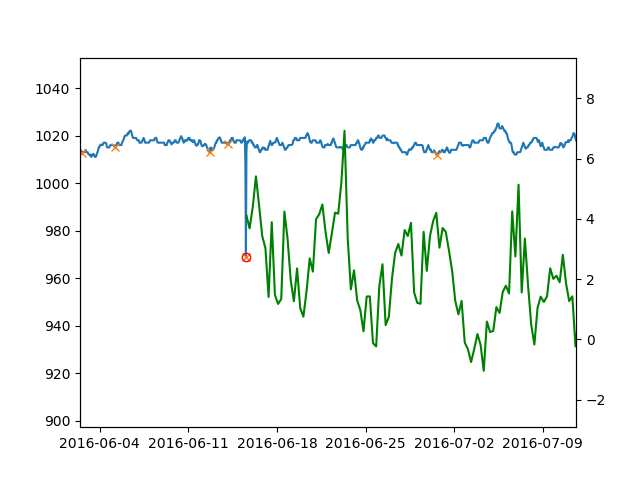

In [519]:
fig, ax = plt.subplots()
plt.plot(p)
plt.plot(p.loc[c.index], 'x')
plt.plot(p.loc[m.index], 'ro', mfc='none')
bx = ax.twinx()
bx.plot(dtPLV.dropna(), 'g')

In [207]:
import cartopy.crs as crs

In [209]:
import xarray as xr

In [221]:
slp = xr.open_dataarray('../../data/analyses/ERA/ERA-SLP-dailymean.nc')

<IPython.core.display.Javascript object>


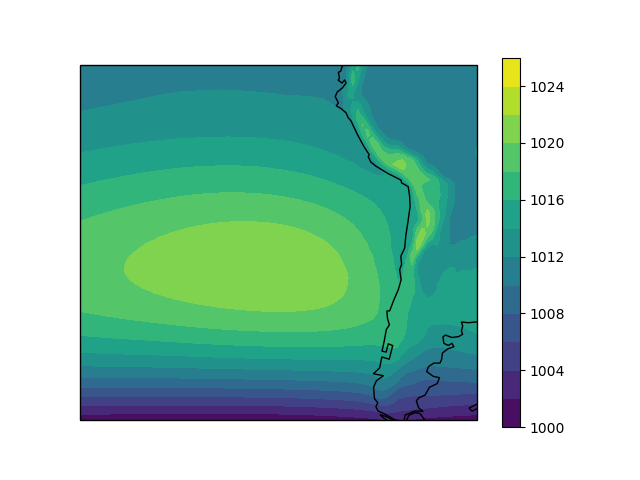

In [291]:
# pm = slp.mean('time')

fig, ax = plt.subplots(subplot_kw={'projection': crs.PlateCarree()})
cnt = np.arange(1000, 1027, 2)

plt.contourf(pm.lon, pm.lat, pm.squeeze()/100, cnt)
ax.set_extent([-120, -60, -50, 0])
ax.coastlines()
plt.colorbar(pl, ax=ax)

<IPython.core.display.Javascript object>


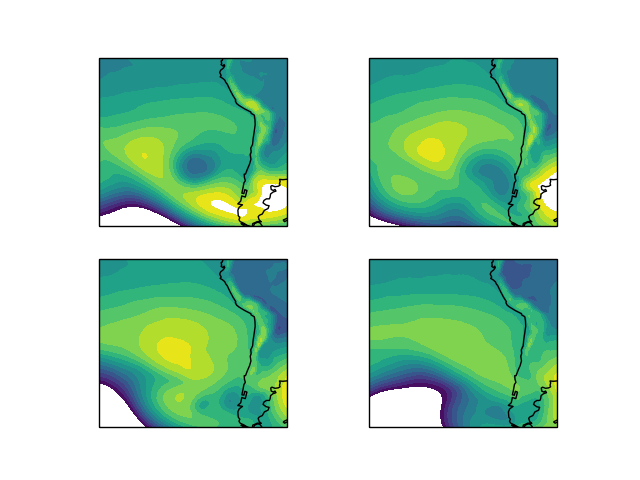

In [289]:
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': crs.PlateCarree()})

cnt = np.arange(1000, 1027, 2)

for i in range(4):
    ax = axs[i//2, i%2]
    pp = slp.sel(time = (m.index[-1] + pd.Timedelta(i-2, 'D')).strftime('%Y-%m-%d'))
    pl = ax.contourf(pp.lon, pp.lat, pp.squeeze()/100, cnt)
    ax.set_extent([-120, -60, -50, 0])
    ax.coastlines()
#     plt.colorbar(pl, ax=ax)

In [349]:
with pd.HDFStore('../../data/CEAZAMet/stations.h5') as S:
    sta= S['stations']
    flds = S['fields']

In [401]:
pf = flds.xs('pa_hpa', 0, 'field').drop('full', 1).join(sta[['lon', 'lat', 'full']])

In [402]:
pf[pf.lat.astype(float) < -35]

,,unit,elev,first,lon,lat,full
station,sensor_code,,,,,,
BK,BKPA,hPa,2,,-74.01520,-47.77000,Canal Baker [Boya]
CNPW,CNPWPA,hPa,2,2010-01-13 20:15:00,-67.61519,-54.93208,Puerto Williams [OMORA]
CNSD,CNSDPA,hPa,2,2010-03-23 11:00:00,-73.67206,-41.88500,Senda Darwin
DICHA,DICHAPA,hPa,2,2016-05-17 12:50:00,-72.93268,-36.54483,Dichato
LB,LBPA,hPa,2,2013-05-14 12:40:00,-72.30889,-41.49583,Cochamó [LOBO]
PUY,PUYPA,hPa,2,2014-04-11 00:11:00,-72.73900,-44.58770,Puyuhuapi
RLCV,RLCVMETPA,hPa,2,2017-09-02 03:40:00,-72.83448,-41.63638,Seno Reloncaví [Imar]
TRT,TRTPA,hPa,2,2015-12-15 17:19:00,-73.54117,-47.80361,Tortel


In [394]:
p35 = D['pa_hpa'][_.index.get_level_values('station')].xs('prom', 1, 'aggr')

In [386]:
del availability_matrix

In [387]:
from plots import availability_matrix

<IPython.core.display.Javascript object>


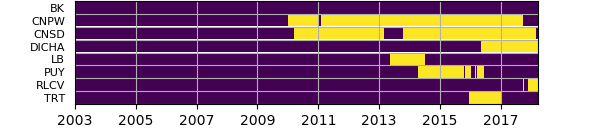

In [400]:
availability_matrix(p35, bottom=.2)

In [475]:
T2 = xr.open_dataarray('../../data/fnl/T2.nc').squeeze()

In [473]:
from scipy.interpolate import interpn

In [463]:
intp = RegularGridInterpolator((T2.time.astype(float).values.flatten(), T2.lat.values.flatten(), T2.lon.values.flatten()-360), T2.squeeze())

In [470]:
gr = np.r_[np.meshgrid(T2.time.astype(float), *sta.loc['PLV'][['lat', 'lon']].astype(float))].squeeze().T

In [487]:
def intp(x, i, sta):
    return interpn((x.lat, x.lon-360), x.sel(time=i), sta[['lat', 'lon']].astype(float))

In [517]:
TPLV = pd.Series([intp(T2, t, sta.loc['PLV']) for t in T2.time], index=T2.time - pd.Timedelta('4h')) - 273.15

In [518]:
dtPLV = (TPLV - hh.stationize(T)['PLV']).dropna()

<IPython.core.display.Javascript object>


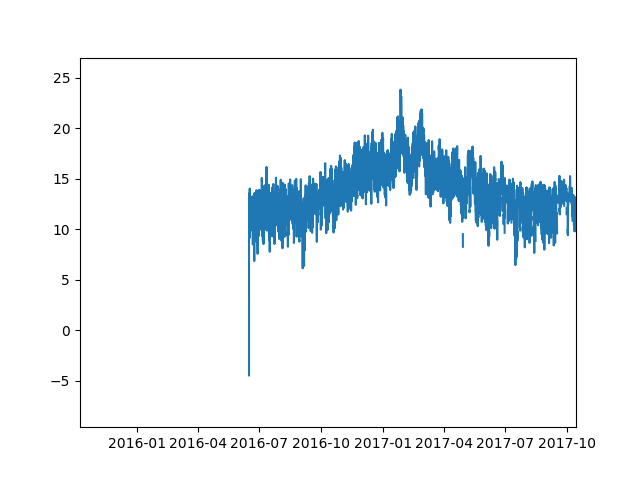

In [522]:
plt.figure()
plt.plot(T['PLV'])